In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import torch
import ipywidgets as widgets

cuda_input = widgets.BoundedIntText(
    value=0,
    min=0,
    max=torch.cuda.device_count() - 1,
    step=1,
    description='GPU to use:',
    disabled=False
)
button = widgets.Button(
    description='Set',
    icon='check'
)

def set_gpu_to_use(btn=None):
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cuda_input.value)
    
display(cuda_input)
set_gpu_to_use()
button.on_click(set_gpu_to_use)
display(button)

BoundedIntText(value=0, description='GPU to use:', max=1)

Button(description='Set', icon='check', style=ButtonStyle())

In [4]:
from torch import functional as F
from torch import nn
from torchvision import datasets, transforms, models
import time
from tqdm import notebook as tqdm
from torch.utils.tensorboard import SummaryWriter

In [5]:
from smoothing import SmoothingWrapper, RepeatableTimer, AverageCounter, MovingAverageCounter

In [6]:
def train(loader, wrapper, criterion, optimizer, writer, epoch, device=torch.device('cpu')):
    wrapper.train()
    loss_cnt = MovingAverageCounter(5)
    timer = RepeatableTimer(1.)
    iteration = (epoch - 1) * len(loader.dataset)

    for X, y in tqdm.tqdm(loader):
        y_pred = torch.sigmoid(wrapper.get_training_output(X.to(device)))
        loss = criterion(y_pred, y.to(device).to(y_pred.dtype))
        
        loss_cnt.add(loss.item())
        iteration += len(y)
        writer.add_scalar('Loss/train', loss_cnt.get_average(), iteration)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(device))
else:
    device = torch.device('cpu')

NVIDIA Tesla K80


In [8]:
img_mean = [0.5063, 0.4258, 0.3832]
img_std = [0.2660, 0.2452, 0.2414]
celeba_transforms = [
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std),
]
celeba_transform = transforms.Compose(celeba_transforms)

celeba_transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
] + celeba_transforms)

In [9]:
celeba_train_dataset = datasets.CelebA('dsets/', split='train', target_type='attr',
                                      download=False, transform=celeba_transform_train)

In [10]:
celeba_test_dataset = datasets.CelebA('dsets/', split='valid', target_type='attr',
                                      download=False, transform=celeba_transform)

In [11]:
class CelebaModel(nn.Module):
    def __init__(self):
        super(CelebaModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Linear(2048, 40)

    def forward(self, x):
        return self.resnet50(x)

In [12]:
batch_size=128

In [13]:
train_loader = torch.utils.data.DataLoader(celeba_train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(celeba_test_dataset, batch_size)

In [14]:
len(train_loader.dataset)

162770

In [14]:
criterion = nn.BCELoss()
wrapper = SmoothingWrapper(CelebaModel().to(device), 1, batch_size)
optimizer = torch.optim.Adam(wrapper.model.parameters(), lr=1e-3)

In [15]:
writer = SummaryWriter(log_dir='runs/celeba-simple')

In [16]:
def uncertified_validate(loader, wrapper, criterion, writer, epoch, device):
    wrapper.eval()
    loss_cnt = AverageCounter()
    accuracy_cnt = AverageCounter()
    with torch.no_grad():
        for X, y in tqdm.tqdm(loader):
            y_pred = torch.sigmoid(wrapper.model(X.to(device)))
            y = y.to(device)
            accuracy_cnt.add(torch.mean(((y_pred > 0.5) == y).to(torch.float)).item())
            loss = criterion(y_pred, y.to(y_pred.dtype))
            loss_cnt.add(loss.item())
        writer.add_scalar('Loss/val', loss_cnt.get_average(), epoch)
        writer.add_scalar('Accuracy/val', accuracy_cnt.get_average(), epoch)

In [ ]:
epoch = 0
while epoch < 10:
    epoch += 1
    print(f'Epoch {epoch}')
    train(train_loader, wrapper, criterion, optimizer, writer, epoch, device)
    torch.save(wrapper.model, f'celeba{epoch:02d}.pth')
    uncertified_validate(test_loader, wrapper, criterion, writer, epoch, device)

Epoch 1


  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/1272 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/1272 [00:00<?, ?it/s]

In [19]:
print('ok')

ok


In [24]:
def get_prediction_counts(model, x, mc_size, batch_size, sigma, xrange=range):
    counts = None
    with torch.no_grad():
        for processed in xrange(0, mc_size, batch_size):
            sz = min(batch_size, mc_size - processed)
            noised_inputs = x.expand(sz, *x.shape)
            noised_inputs = noised_inputs + torch.randn_like(noised_inputs, device=noised_inputs.device) * sigma
            outputs = (model(noised_inputs) > 0).to(torch.int64)
            if counts is None:
                counts = torch.zeros(2, outputs.shape[1], dtype=torch.int64, device=outputs.device)
            add = torch.sum(outputs, dim=0)
            counts[1] += add
            counts[0] += sz - add
    return counts

from scipy.stats import norm, binom_test
from statsmodels.stats.proportion import proportion_confint
def certify(model, x, n_sel, n_est, alpha, sigma, xrange=range):
    """ Certify radius with probability 1 - alpha
    :param x: the input [channel x height x width]
    :param n_sel: the number of Monte Carlo samples to use for selection
    :param n_est: the number of Monte Carlo samples to use for estimation
    :param alpha: the error probability
    :return: (predicted classes, certified radii), if the prediction was rejected, the predicted class is 2 and radius 0
    """
        
    counts_selection = get_prediction_counts(model, x, n_sel, batch_size, sigma, xrange=xrange)
    predicted_class = (counts_selection[1] > counts_selection[0]).to(torch.int64)
    counts_est = get_prediction_counts(model, x, n_est, batch_size, sigma, xrange=xrange)
    
    result_class = []
    result_radius = []
    
    for i in range(len(predicted_class)):
        count_est = counts_est[predicted_class[i].item(),i].item()
        est_lo, est_hi = proportion_confint(count_est, n_est, 2 * alpha, method='beta')
        if est_lo < 0.05:
            result_class.append(2)
            result_radius.append(0.)
        else:
            result_class.append(predicted_class[i].item())
            result_radius.append(sigma * norm.ppf(est_lo))
            
    return torch.tensor(result_class), torch.tensor(result_radius)

In [25]:
def certified_accuracy(pred_cl, pred_radius, target_cl, threshold_radius):
    return torch.mean(((pred_cl == target_cl) & (pred_radius >= threshold_radius)).to(torch.float)).item()

In [26]:
model = wrapper.model

In [28]:
predicted_classes = []
targets = []
predicted_radii = []
for i in tqdm.trange(25):
    img, target = celeba_test_dataset[i]
    res_cl, res_rad = certify(model, img.to(device), 10**3, 10**4, 1e-3, 1.)
    predicted_classes.append(res_cl)
    predicted_radii.append(res_rad)
    targets.append(target)
predicted_classes = torch.stack(predicted_classes)
targets = torch.stack(targets)
predicted_radii = torch.stack(predicted_radii)

  0%|          | 0/25 [00:00<?, ?it/s]

In [29]:
torch.save({'y': targets, 'y_pred': predicted_classes, 'r': predicted_radii}, 'eval10.pth')

In [32]:
radii = np.linspace(0, 5)
res = []
for i, r in enumerate(radii):
    res.append(certified_accuracy(predicted_classes.view(-1), predicted_radii.view(-1), targets.view(-1), r))

In [1]:
predicted_radii.max()

NameError: name 'predicted_radii' is not defined

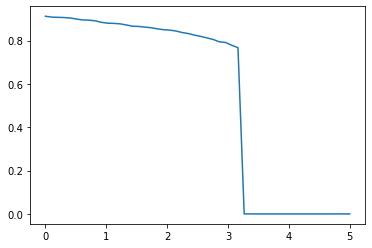

In [33]:
fig, ax = plt.subplots()
ax.plot(radii, res)

In [41]:
def test(dataset, wrapper, n, alpha, radii, device):
    wrapper.eval()
    radii = np.asarray(radii)
    accuracies = np.zeros(len(radii))
    printer = PeriodicPrinter(5)
    res = np.zeros(len(dataset))
    for i, (X, y) in enumerate(dataset):
        cl, radius = wrapper.certify(X.to(device), n, n, alpha)
        if cl == y:
            res[i] = radius
            accuracies[radii < radius] += 1
        else:
            res[i] = float('nan')
        if printer.print(f'Iteration {i + 1}'):
            for r, a in zip(radii, accuracies / (1 + i) * 100):
                 print(f'Accuracy @ {r} = {a}%')
    for r, a in zip(radii, accuracies / len(dataset)):
        print(f'Accuracy @ {r} = {a * 100}%')
    return res

In [ ]:
res = test(mnist_test_dataset, wrapper, 10000, 0.001, [0, 1., 2.5, 3., 3.5, 4., 4.5, 5., 10.], device)

Iteration 1
Accuracy @ 0.0 = 100.0%
Accuracy @ 1.0 = 100.0%
Accuracy @ 2.5 = 100.0%
Accuracy @ 3.0 = 100.0%
Accuracy @ 3.5 = 0.0%
Accuracy @ 4.0 = 0.0%
Accuracy @ 4.5 = 0.0%
Accuracy @ 5.0 = 0.0%
Accuracy @ 10.0 = 0.0%
Iteration 9
Accuracy @ 0.0 = 100.0%
Accuracy @ 1.0 = 100.0%
Accuracy @ 2.5 = 88.88888888888889%
Accuracy @ 3.0 = 88.88888888888889%
Accuracy @ 3.5 = 0.0%
Accuracy @ 4.0 = 0.0%
Accuracy @ 4.5 = 0.0%
Accuracy @ 5.0 = 0.0%
Accuracy @ 10.0 = 0.0%
Iteration 17
Accuracy @ 0.0 = 100.0%
Accuracy @ 1.0 = 100.0%
Accuracy @ 2.5 = 94.11764705882352%
Accuracy @ 3.0 = 94.11764705882352%
Accuracy @ 3.5 = 0.0%
Accuracy @ 4.0 = 0.0%
Accuracy @ 4.5 = 0.0%
Accuracy @ 5.0 = 0.0%
Accuracy @ 10.0 = 0.0%
Iteration 25
Accuracy @ 0.0 = 100.0%
Accuracy @ 1.0 = 96.0%
Accuracy @ 2.5 = 92.0%
Accuracy @ 3.0 = 84.0%
Accuracy @ 3.5 = 0.0%
Accuracy @ 4.0 = 0.0%
Accuracy @ 4.5 = 0.0%
Accuracy @ 5.0 = 0.0%
Accuracy @ 10.0 = 0.0%
Iteration 33
Accuracy @ 0.0 = 100.0%
Accuracy @ 1.0 = 96.96969696969697%
Accu

In [32]:
len(mnist_test_dataset)

10000